In [152]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import auc, roc_curve, average_precision_score, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.calibration import CalibrationDisplay

## Balanced Classes, Easily Seperable

We start with a best case scenario. Classes are equally balanced 50/50.

The features are also very informative meaning the separation of the classes is easily learned by a model. 

In [153]:
x_base, y_base = make_classification(n_samples = 100000,
                                     n_features = 20,
                                     n_informative = 10,
                                     n_redundant=3,
                                     class_sep = 0.75
                                     )

x_train_base, x_test_base, y_train_base, y_test_base = train_test_split(x_base, y_base, test_size=0.2, random_state=1)

### Random Forest

First we fit a random forest to the data.

A Random Forest is a collection of Decision Trees built independently each with a random subset of the data and features.

In [154]:
randomf_fit = RandomForestClassifier(n_estimators = 200, #<-- model hyperparameters changing them effects the form the model takes
                                     max_depth = 5 #this can alter the performance (both good and bad) and change the calibration
                                     )

rf_model = randomf_fit.fit(x_train_base, y_train_base)
test_base_rf = randomf_fit.predict_proba(x_test_base)[:, 1]

<Axes: ylabel='Count'>

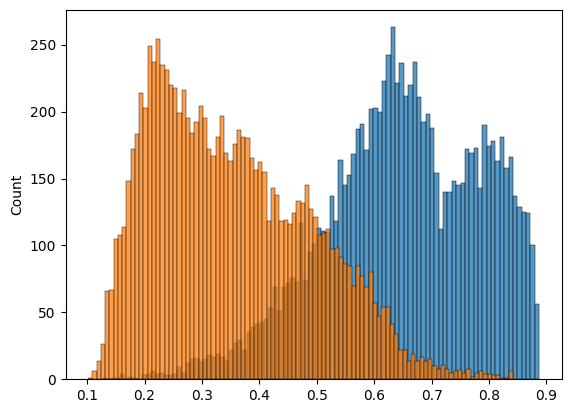

In [155]:
sns.histplot(test_base_rf[y_test_base==1], bins=100)
sns.histplot(test_base_rf[y_test_base==0], bins=100)

Above we see the distribution of predictions on our test data.

The model seperates the classes reasonably well.

However notice the range the predictions takes `[0.1 - 0.9]`.

This is due to properties of random forests that make predicting extreme values difficult.

This will affect the calibration of the model.

Depsite this the model is still very predictive as shown below by the AUC and AP metrics.

In [156]:
fpr_base, tpr_base, thresholds_base = roc_curve(y_test_base, test_base_rf)
print("AUC: ", auc(fpr_base, tpr_base))
print("AP: ", average_precision_score(y_test_base, test_base_rf))

AUC:  0.9262640346901052
AP:  0.9241277490451595


Using a calibration plot we can visualise the translation of model output to actual %.

Along the x-axis is the predicted propensity outputted from the model.

Along the y-axis is the actual % of positives cases.

The dashed line represents perfect calibration where the model output can be interpretted directly as a % of being a target case.

The blue line shows how the model strays from this, with it under representing positives in low scores and over representing high scores.

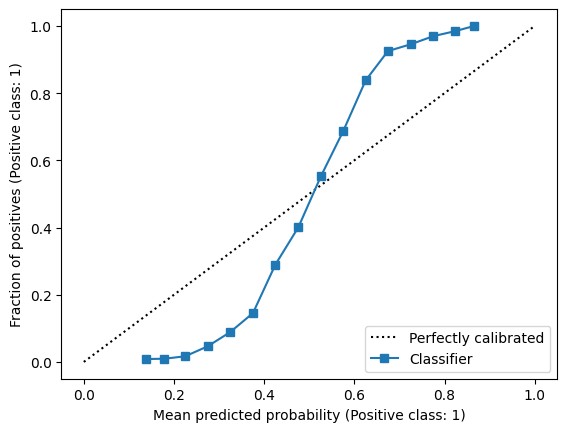

In [157]:
calib_display = CalibrationDisplay.from_predictions(y_test_base, test_base_rf, n_bins=20, strategy='uniform', ref_line=True)

## XGBoost

Now we fit an XGBoost model to the same data.

While still a tree based model like a Random Forest it is constructed in a different way.

Rather than being independently built each subsequent tree uses errors from the previous tree to inform the next tree.

This can lead to more predictive models and changes the calibration of the model.

In [160]:
xgboost_fit = XGBClassifier(n_estimators = 200,
                            max_depth = 5,
                            learning_rate = 0.05,
                            colsample_bytree=0.9
                            )

xg_model = xgboost_fit.fit(x_train_base, y_train_base)

In [161]:
test_base_xg = xgboost_fit.predict_proba(x_test_base)[:, 1]

<Axes: ylabel='Count'>

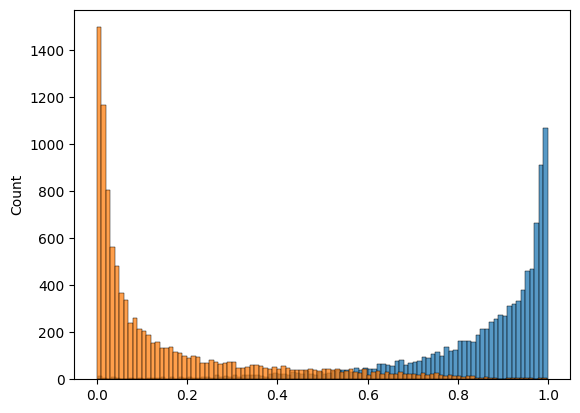

In [162]:
sns.histplot(test_base_xg[y_test_base==1], bins=100)
sns.histplot(test_base_xg[y_test_base==0], bins=100)

We can see above that the predictions now take the full range of `[0 - 1]`.

The classes are also more separated than the Random Forest due to the increased predictive power of the XGBoost model. 

An improvement in accuracy can be seen by the increase in AUC and AP below.

In [163]:
fpr_base, tpr_base, thresholds_base = roc_curve(y_test_base, test_base_xg)
print("AUC: ", auc(fpr_base, tpr_base))
print("AP: ", average_precision_score(y_test_base, test_base_xg))


AUC:  0.9764677506904511
AP:  0.9752720286981978


The calibration plot for the XGBoost model shows much improvement over the Random Forest.

This is evident by the blue line being much closer to the dashed ideal line.

Even with it's predictive power being very high it is still not perfectly calibrated.

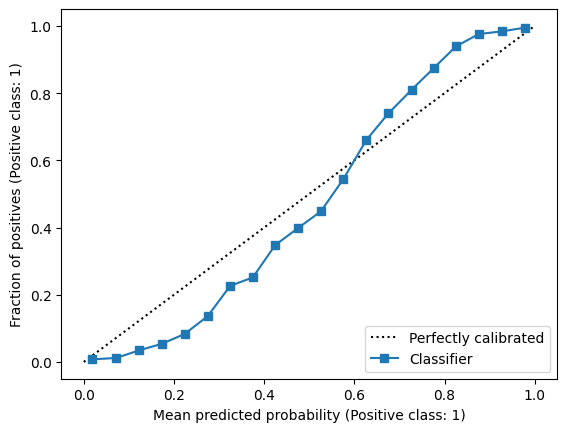

In [165]:
calib_display = CalibrationDisplay.from_predictions(y_test_base, test_base_xg, n_bins=20, strategy='uniform', ref_line=True)

## Lower Accuracy Model

To show the affect of model accuracy we will introduce more overlap and noise into the dataset.

This will make it more difficult for the model to separate the classes.

In [227]:
x_low, y_low = make_classification(n_samples = 100000,
                                   n_features = 20,
                                   n_informative = 10,
                                   n_redundant=3,
                                   class_sep = 0.3, #<-- separation of classes
                                   flip_y=0.1 #<-- % of targets assigned randomly
                                   )

x_train_low, x_test_low, y_train_low, y_test_low = train_test_split(x_low, y_low, test_size=0.2, random_state=1)

In [228]:
xgboost_low = XGBClassifier(n_estimators = 200,
                            max_depth = 5,
                            learning_rate = 0.05,
                            colsample_bytree=0.9
                            )

xg_low = xgboost_low.fit(x_train_low, y_train_low)
test_low_xg = xgboost_low.predict_proba(x_test_low)[:, 1]

<Axes: ylabel='Count'>

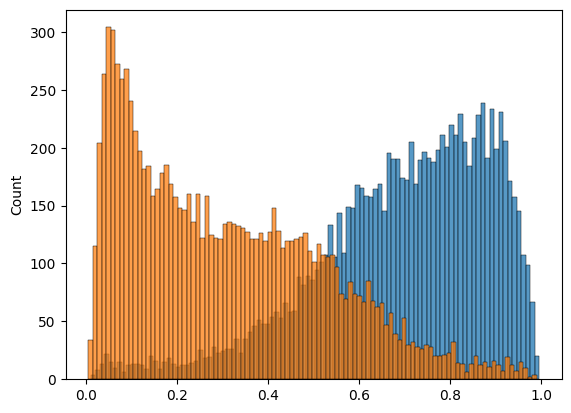

In [229]:
sns.histplot(test_low_xg[y_test_low==1], bins=100)
sns.histplot(test_low_xg[y_test_low==0], bins=100)

In [230]:
fpr_low, tpr_low, thresholds_low = roc_curve(y_test_low, test_low_xg)
print("AUC: ", auc(fpr_low, tpr_low))
print("AP: ", average_precision_score(y_test_low, test_low_xg))

AUC:  0.895416990407459
AP:  0.8802910830296999


We can see above from the score distribution and AUC/AP metrics that the model has much less predictive power than before.

However looking at the calibration plot we can see that it hasn't changed much in comparision.

This shows that highly predictive models do not guarantee good calibration, and that good calibration is still possible with underperforming models.

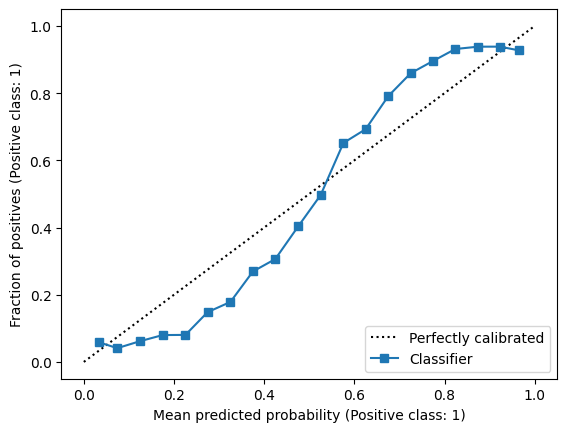

In [231]:
calib_display = CalibrationDisplay.from_predictions(y_test_low, test_low_xg, n_bins=20, strategy='uniform', ref_line=True)

## Imbalanced Data

We now give an example of how class imbalance can affect calibration.

There is now a 90/10 split between negative/postive classes.

The classes have been returned to their original separability.

In [166]:
x_imbal, y_imbal = make_classification(n_samples = 100000,
                                       n_features = 20,
                                       n_informative = 10,
                                       n_redundant=3,
                                       class_sep = 0.75,
                                       weights=[0.90] #<-- balance between classes
                                       )

x_train_imbal, x_test_imbal, y_train_imbal, y_test_imbal = train_test_split(x_imbal, y_imbal, test_size=0.2, random_state=1)

In [167]:
xgboost_imbal = XGBClassifier(n_estimators = 200,
                            max_depth = 5,
                            learning_rate = 0.05,
                            colsample_bytree=0.9
                            )

xg_imbal = xgboost_imbal.fit(x_train_imbal, y_train_imbal)
test_imbal_xg = xgboost_imbal.predict_proba(x_test_imbal)[:, 1]

<Axes: ylabel='Count'>

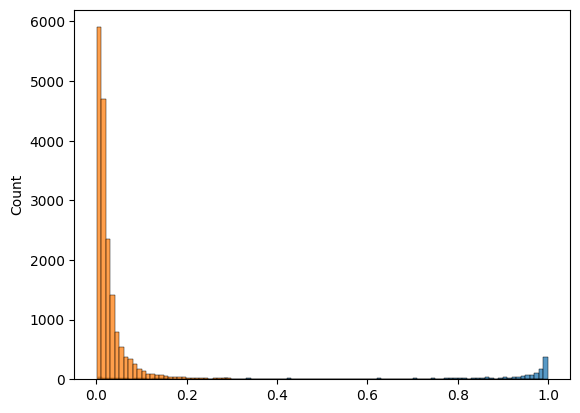

In [168]:
sns.histplot(test_imbal_xg[y_test_imbal==1], bins=100)
sns.histplot(test_imbal_xg[y_test_imbal==0], bins=100)

In [169]:
fpr_imbal, tpr_imbal, thresholds_imbal = roc_curve(y_test_imbal, test_imbal_xg)
print("AUC: ", auc(fpr_imbal, tpr_imbal))
print("AP: ", average_precision_score(y_test_imbal, test_imbal_xg))

AUC:  0.9690235257655191
AP:  0.9103469376021042


While we still see high performance indicated by the AUC and AP, we see a much different distribution of scores.

The negative class dominates the distribution with a large number of scores close to 0.

There are then very few scores in the middle range before the small number of positive scores towards 1.

We can see the effect this has on the calibration below.

It also serves as a warning that calibration curves can be unreliable when there is a lack data in a predictied score range.

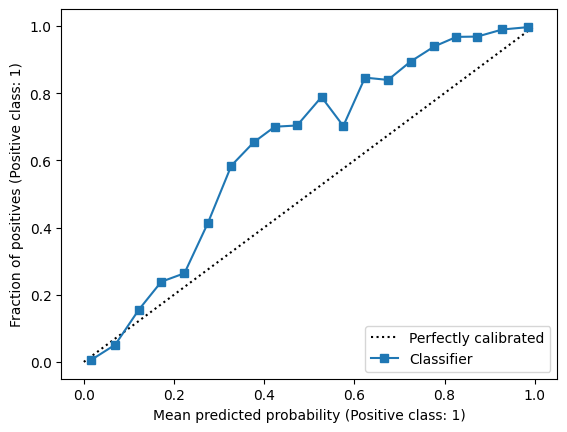

In [172]:
calib_display = CalibrationDisplay.from_predictions(y_test_imbal, test_imbal_xg, n_bins=20, strategy='uniform', ref_line=True)

## Imbalanced + Lower Accuracy

We now combine the imbalanced class and the lower accuracy problems together.

In [232]:
x_imbal_low, y_imbal_low = make_classification(n_samples = 100000,
                                               n_features = 20,
                                               n_informative = 10,
                                               n_redundant=3,
                                               class_sep = 0.3, #<-- separation of classes
                                               flip_y=0.1, #<-- % of targets assigned randomly
                                               weights=[0.90]
                                               )

x_train_imbal_low, x_test_imbal_low, y_train_imbal_low, y_test_imbal_low = train_test_split(x_imbal_low, y_imbal_low, test_size=0.2, random_state=1)

In [237]:
xgboost_imbal_low = XGBClassifier(n_estimators = 200,
                            max_depth = 5,
                            learning_rate = 0.05,
                            colsample_bytree=0.9
                            )

xg_imbal_low = xgboost_imbal_low.fit(x_train_imbal_low, y_train_imbal_low)
test_imbal_low = xgboost_imbal_low.predict_proba(x_test_imbal_low)[:, 1]

<Axes: ylabel='Count'>

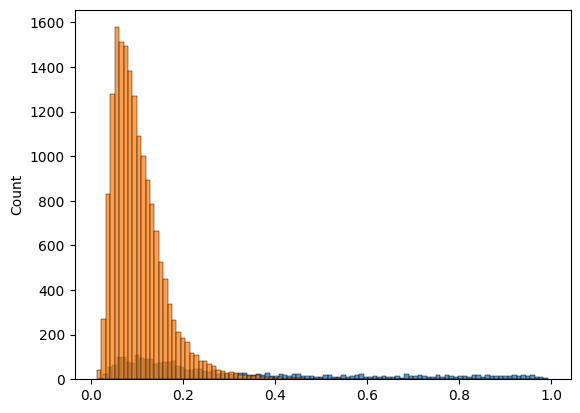

In [238]:
sns.histplot(test_imbal_low[y_test_imbal_low==1], bins=100)
sns.histplot(test_imbal_low[y_test_imbal_low==0], bins=100)

In [239]:
fpr_imbal_low, tpr_imbal_low, thresholds_imbal_low = roc_curve(y_test_imbal_low, test_imbal_low)
print("AUC: ", auc(fpr_imbal_low, tpr_imbal_low))
print("AP: ", average_precision_score(y_test_imbal_low, test_imbal_low))

AUC:  0.7967935106575716
AP:  0.5939778791019854


The imbalance of classes and lower accuracy combined harm the calibration further.

Although it is to be noted that where there is a large amount of data around `0.1` the model is well calibrated.

The more sparse the data is the more erractic the calibration becomes.

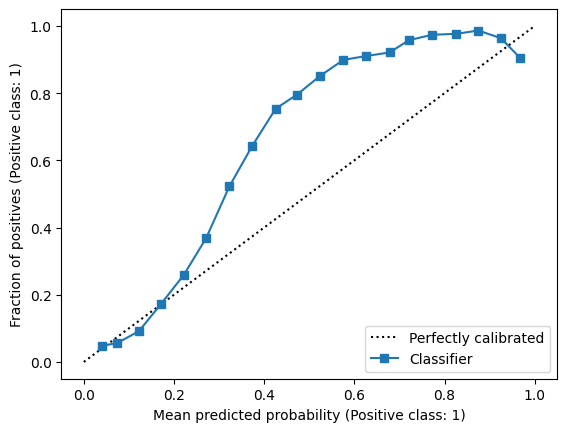

In [240]:
calib_display = CalibrationDisplay.from_predictions(y_test_imbal_low, test_imbal_low, n_bins=20, strategy='uniform', ref_line=True)

## Messing With Hyperparameters

Finally alogrithms contain many other knobs and dials known as hyperparameters to tweak the construction and performance of the model.

These are usually set through testing a range of hyperparameter combinations via cross validation.

Some of the parameters will affect the output more than others.

In [269]:
xgboost_imbal_hp = XGBClassifier(n_estimators = 300, #<-- number of trees created
                                 max_depth = 5, #<-- number of splits a tree can make
                                 learning_rate = 0.05, #<-- controls importance of learnings from previous trees 
                                 subsample=0.8, #<-- % training data in each tree
                                 colsample_bytree=0.9, #<-- % of features in each tree
                                 scale_pos_weight = 5 #<-- adds weighting to make predicting a class more important to the model
                            )

xg_imbal_hp = xgboost_imbal_hp.fit(x_train_imbal_low, y_train_imbal_low)
test_imbal_hp = xgboost_imbal_hp.predict_proba(x_test_imbal_low)[:, 1]

<Axes: ylabel='Count'>

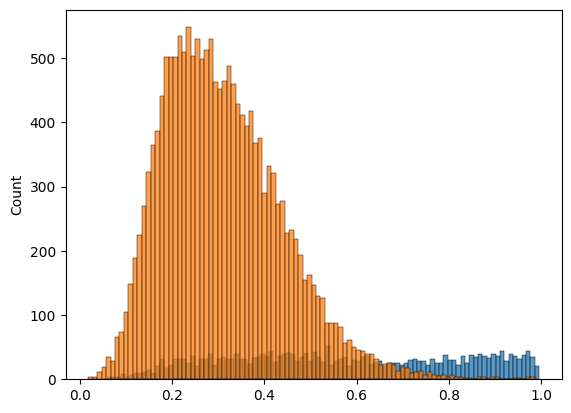

In [270]:
sns.histplot(test_imbal_hp[y_test_imbal_low==1], bins=100)
sns.histplot(test_imbal_hp[y_test_imbal_low==0], bins=100)

In [271]:
fpr_imbal_hp, tpr_imbal_hp, thresholds_imbal_hp = roc_curve(y_test_imbal_low, test_imbal_hp)
print("AUC: ", auc(fpr_imbal_hp, tpr_imbal_hp))
print("AP: ", average_precision_score(y_test_imbal_low, test_imbal_hp))

AUC:  0.805930175795004
AP:  0.6110418724562665


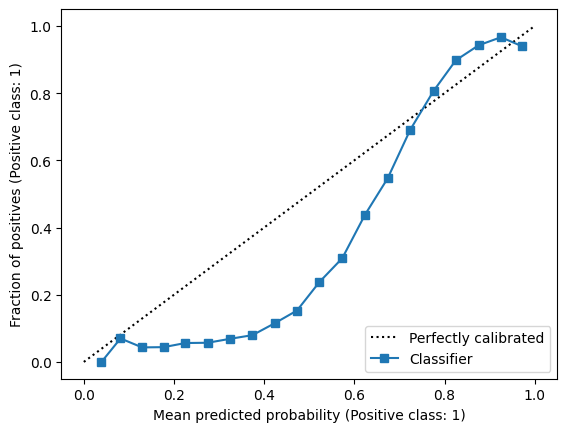

In [272]:
calib_display = CalibrationDisplay.from_predictions(y_test_imbal_low, test_imbal_hp, n_bins=20, strategy='uniform', ref_line=True)

Above we can see that introducing new hyperparameters as well as changing existing ones can improve the accuracy.

It also has drastic effects on the calibration of the model.

Change some of the values and rerun the code to see what happens.